##### Importar Libs

In [183]:
# Importar Libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from optbinning import OptimalBinning, BinningProcess
from sklearn.metrics import roc_curve, roc_auc_score
import pickle



##### Carregar Conjunto de Dados

In [184]:
# Ler os dados
data = pd.read_csv('UCI_Credit_Card.csv')

#### Split Data

In [185]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(data.drop(['ID', 'default.payment.next.month'], axis=1), 
                                                    data['default.payment.next.month'], 
                                                    test_size=0.3, 
                                                    random_state=42)

##### Pré-processamento de Dados

In [186]:
# Listar nome das variáveis
variable_names = X_train.columns.unique().tolist()

categorical_variables = X_train.select_dtypes(include='object')
categorical_variables = categorical_variables.columns.unique().tolist()

In [187]:
# Processar bining
binning_process = BinningProcess(variable_names, categorical_variables=categorical_variables,
                                min_prebin_size = 0.10, max_n_bins=7)

In [188]:
binning_process.fit(X_train, y_train)

BinningProcess(categorical_variables=[], max_n_bins=7, min_prebin_size=0.1,
               variable_names=['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE',
                               'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4',
                               'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
                               'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                               'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
                               'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])

In [189]:
BinningProcess(categorical_variables=categorical_variables,
               max_n_bins=5,
               variable_names=variable_names)

BinningProcess(categorical_variables=[], max_n_bins=5,
               variable_names=['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE',
                               'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4',
                               'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
                               'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                               'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
                               'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])

In [190]:
df_iv = binning_process.summary().sort_values(by=['iv'], ascending=False)
df_iv

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
5,PAY_0,numerical,OPTIMAL,True,4,0.881628,0.098239,0.424856,0.240999
6,PAY_2,numerical,OPTIMAL,True,4,0.574944,0.066814,0.312897,0.07106
7,PAY_3,numerical,OPTIMAL,True,4,0.440111,0.051683,0.27603,0.764083
8,PAY_4,numerical,OPTIMAL,True,4,0.371824,0.043483,0.241605,0.7505
10,PAY_6,numerical,OPTIMAL,True,4,0.286857,0.033743,0.207634,0.698827
17,PAY_AMT1,numerical,OPTIMAL,True,5,0.185078,0.022713,0.226419,0.597434
0,LIMIT_BAL,numerical,OPTIMAL,True,7,0.183408,0.02256,0.237511,0.453389
18,PAY_AMT2,numerical,OPTIMAL,True,5,0.162522,0.019912,0.211861,0.560015
19,PAY_AMT3,numerical,OPTIMAL,True,6,0.133184,0.016427,0.198629,0.4355
20,PAY_AMT4,numerical,OPTIMAL,True,6,0.106919,0.013242,0.181324,0.356566


In [191]:
# Criar uma lista com o nome das variáveis a serem removidas
cols_to_drop = df_iv.loc[df_iv['iv'] < 0.02]['name'].tolist()

# Dropar as colunas do DataFrame
X_train = X_train.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)

##### Train Model

###### LogisticRegression

In [192]:
# Construir o modelo
model = LogisticRegression()

# Treinar o modelo
model.fit(X_train, y_train)

LogisticRegression()

Acurácia: 0.7822222222222223
Precisão: 0.0
Recall: 0.0
F1-score: 0.0


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


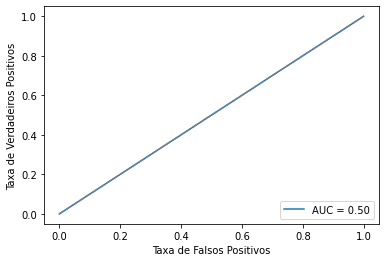

In [193]:
# Fazer as previsões nos dados de teste
y_pred = model.predict(X_test)

# Calcular as métricas
print('Acurácia:', accuracy_score(y_test, y_pred))
print('Precisão:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1-score:', f1_score(y_test, y_pred))

# Calcular a curva ROC e a AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Plotar a curva ROC

plt.plot(fpr, tpr, label='AUC = %.2f' % auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.show()

In [194]:
# Matriz de confusão
confusion_matrix(y_test, y_pred)

array([[7040,    0],
       [1960,    0]], dtype=int64)

###### RandomForest

In [195]:
from sklearn.ensemble import RandomForestClassifier

# Construir o modelo
rf_model = RandomForestClassifier()

# Treinar o modelo
rf_model.fit(X_train, y_train)

# Fazer as previsões nos dados de teste
rf_y_pred = rf_model.predict(X_test)

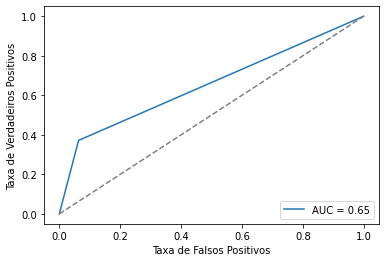

Random Forest:
Acurácia: 0.8136666666666666
Precisão: 0.6204255319148936
Recall: 0.3719387755102041
F1-score: 0.46507177033492825


In [196]:
# Calcular as métricas

# Calcular a curva ROC e a AUC
fpr, tpr, thresholds = roc_curve(y_test, rf_y_pred)
auc = roc_auc_score(y_test, rf_y_pred)

# Plotar a curva ROC
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='AUC = %.2f' % auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.show()

print('Random Forest:')
print('Acurácia:', accuracy_score(y_test, rf_y_pred))
print('Precisão:', precision_score(y_test, rf_y_pred))
print('Recall:', recall_score(y_test, rf_y_pred))
print('F1-score:', f1_score(y_test, rf_y_pred))

###### XGBoost

In [197]:
import xgboost as xgb

# Converter os dados para o formato xgb.DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definir os parâmetros do modelo
params = {
    'objective': 'binary:logistic',  # classificação binária
    'eval_metric': 'auc',
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 1,
    'seed': 42,
    'nthread': -1
}

# Treinar o modelo
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Fazer as previsões nos dados de teste
xgb_y_pred = xgb_model.predict(dtest)

# Arredondar as previsões para 0 ou 1
xgb_y_pred = np.round(xgb_y_pred)

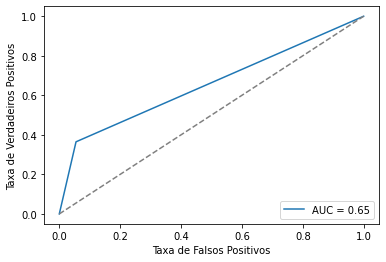

XGBoost:
Acurácia: 0.8186666666666667
Precisão: 0.6488203266787659
Recall: 0.3647959183673469
F1-score: 0.4670150228608752


In [198]:
# Calcular as métricas

# Calcular a curva ROC e a AUC
fpr, tpr, thresholds = roc_curve(y_test, xgb_y_pred)
auc = roc_auc_score(y_test, xgb_y_pred)

# Plotar a curva ROC

plt.plot(fpr, tpr, label='AUC = %.2f' % auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.show()

print('XGBoost:')
print('Acurácia:', accuracy_score(y_test, xgb_y_pred))
print('Precisão:', precision_score(y_test, xgb_y_pred))
print('Recall:', recall_score(y_test, xgb_y_pred))
print('F1-score:', f1_score(y_test, xgb_y_pred))

##### Avaliação de Desempenho do Modelo

     
     Ao comparar as métricas de precisão, recall e F1-score, é possível observar que o modelo de XGBoost obteve melhores resultados do que o modelo de Random Forest em todas as três métricas. Isso sugere que o modelo de XGBoost tem um desempenho melhor em detectar corretamente os casos positivos (por exemplo, clientes que realmente irão inadimplir) e minimizar os casos falsos positivos (clientes que são classificados como inadimplentes erroneamente).

     O valor AUC varia de 0 a 1, sendo 1 o melhor valor possível, indicando um modelo perfeito. Portanto, um valor AUC de 0.65 indica que o modelo tem uma capacidade razoável de classificar corretamente as amostras, que unido às demais métricas consideramos um potencial preditivo aceitável.

     Após isso calculamos os valores de VIF para verificar se existem problemas de multicolineariedade. Consideramos como problemáticos valores superiores a 5.

In [199]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcular VIF
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif


In [200]:
# VIF Referente às explicativas XGBoost
for col in X_train.columns:
    if col != 'PAY_AMT1':
        X_temp = X_train.drop(['PAY_AMT1'], axis=1)
        vif = calc_vif(X_temp)
        print(f'Variável {col}, VIF: {vif.loc[vif["variables"]==col, "VIF"].values[0]}')

Variável LIMIT_BAL, VIF: 3.3377568107817934
Variável AGE, VIF: 2.7742362487704884
Variável PAY_0, VIF: 1.9097323401108852
Variável PAY_2, VIF: 3.1571455464452964
Variável PAY_3, VIF: 3.7274636796401692
Variável PAY_4, VIF: 4.436454434415598
Variável PAY_5, VIF: 4.971259844195148
Variável PAY_6, VIF: 3.3472939930739454
Variável PAY_AMT2, VIF: 1.199713049629571
Variável PAY_AMT3, VIF: 1.264167657867389
Variável PAY_AMT4, VIF: 1.2465957445043443
Variável PAY_AMT5, VIF: 1.2049173894697152
Variável PAY_AMT6, VIF: 1.190439621562204


     
     Todas as variáveis explicativas estão com valores de VIF abaixo de 5, o que sugere que não há um alto grau de correlação entre elas.

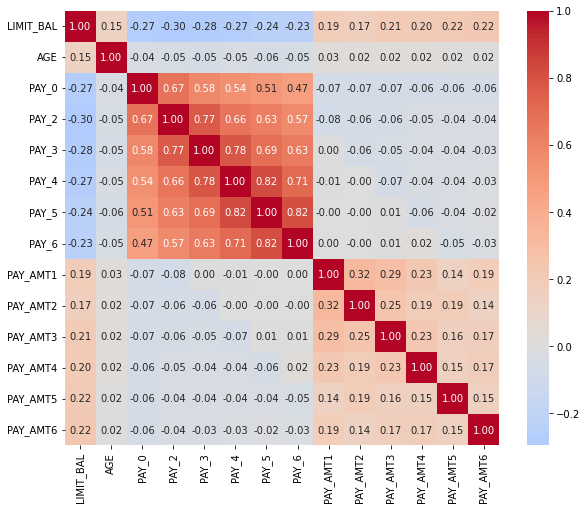

In [201]:
import seaborn as sns

# Criar matriz de correlação
corr_matrix = X_train.corr()

# Gerar heatmap com a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, annot=True, fmt='.2f')
plt.show()

##### Modelo Final - XGBoost

In [202]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from scipy.stats import ks_2samp
import shap

     
     Considerando os resultados anteriores, optamos por utilizar XGBoost como modelo preditivo final. Validamos em 5 folds, treinando o modelo 405 vezes para elencar os melhores parâmetros a serem utilizados na validação final.

In [203]:
# Convertendo os dados para o formato xgb.DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definindo os parâmetros do modelo
params = {
    'objective': 'binary:logistic',  # classificação binária
    'eval_metric': 'auc',
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 1,
    'nthread': -1
}

# Realizando a validação cruzada para ajustar os hiperparâmetros
cv_params = {
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(**params, random_state=42),
    param_grid=cv_params,
    scoring='roc_auc',
    cv=5,
    verbose=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print('Melhores parâmetros:', grid_search.best_params_)
print('Melhor score AUC:', grid_search.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Melhores parâmetros: {'colsample_bytree': 1.0, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 1.0}
Melhor score AUC: 0.77934045137088


In [204]:
# Atualizar parmâmetros com os melhores parâmetros na grade
params.update(grid_search.best_params_)

# Treinando o modelo com os melhores parâmetros
xgb_model = xgb.XGBClassifier(**params, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

# Fazendo as previsões nos dados de teste
xgb_y_pred = xgb_model.predict_proba(X_test)[:, 1]

XGBoost:
AUC: 0.7710638914656771
Precisão-Recall AUC: 0.533354407265482


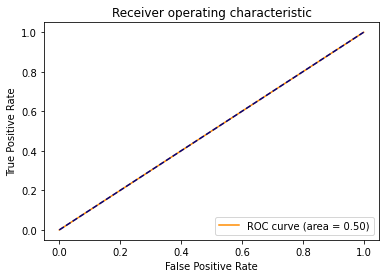

In [205]:
from sklearn.metrics import precision_recall_curve, auc

# Calculando as métricas
print('XGBoost:')
print('AUC:', roc_auc_score(y_test, xgb_y_pred))
precision, recall, _ = precision_recall_curve(y_test, xgb_y_pred)
print('Precisão-Recall AUC:', auc(recall, precision))

# Curva ROC

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [215]:
# Treinar o modelo com todos os dados de treino
final_model_all = xgb.train(params, dtrain, num_boost_round=100)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


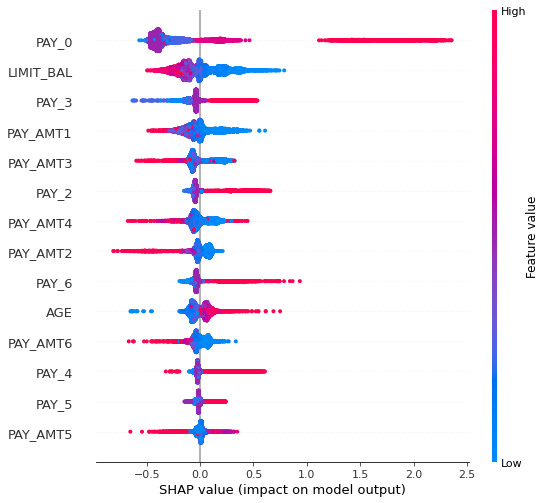

In [216]:
# Predições do modelo por valores SHAP
explainer = shap.Explainer(final_model_all)
shap_values = explainer(X_test)

# Plotar SHAP
shap.summary_plot(shap_values, X_test)

     
     Os valores SHAP demonstram a probabilidade de classificação do modelo através da consideração das variáveis.

     Distribuimos a probabilidade de default para averiguar a classificação do modelo e calculamos KS2 para verificar se o ordenamento é coerente com o esperado em um sistema de classificação de crédito.


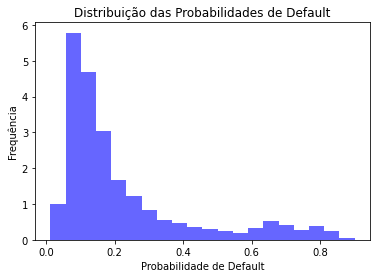

In [217]:
# Distribuição das Probabilidades
plt.hist(xgb_y_pred, bins=20, density=True, alpha=0.6, color='b')
plt.xlabel('Probabilidade de Default')
plt.ylabel('Frequência')
plt.title('Distribuição das Probabilidades de Default')
plt.show()

In [218]:
# Calcular KS2
ks_stat, ks_p_value = ks_2samp(y_test, xgb_y_pred)
print('KS2:', ks_stat)

KS2: 0.7822222222222223


     
     Transformamos a classificação do modelo em um score de 300 até 1000 (similar as classificações de mercado), e por fim criamos faixas desse score para substituir a máscara de classificação do modelo, tendo por fim um output que tenha entendimento por parte das áreas do negócio.

In [219]:
# Transformar Classificação em um SCORE de 300 a 1000

def default_prob_to_score(prob):
    score = 1000 - (prob * 700)
    return score


score_predictions = default_prob_to_score(xgb_y_pred)

# Para visualizar as previsões de score
print(score_predictions)

[895.98206 945.7752  912.50525 ... 923.7758  945.4711  955.95636]


In [220]:
# Criar faixas de SCORE Crescente
bins = [300, 400, 500, 600, 700, 1000]
labels = ['Muito Alto Risco', 'Alto Risco', 'Médio Risco', 'Baixo Risco', 'Muito Baixo Risco']

# Categorizar score com faixa específica
score_categories = pd.cut(score_predictions, bins=bins, labels=labels)

##### Exportação para Pickle (.pkl)

In [221]:
# Salvar classificação em pickle
client_classification = pd.DataFrame({'ID': X_test.index, 'Score': score_predictions, 'Risco': score_categories})

with open('client_classification.pickle', 'wb') as f:
    pickle.dump(client_classification, f)

In [222]:
# Salvar modelo final e resultados em arquivo pickle
xgb_model.save_model('xgb_model.bin')

model_results = {'AUC': roc_auc_score(y_test, xgb_y_pred),
                 'Precision-Recall AUC': auc(recall, precision),
                 'KS2': ks_stat,
                 'Score Bins': bins,
                 'Score Labels': labels,
                  'Model Params': params
}

with open('model_results.pickle', 'wb') as f:
    pickle.dump(model_results, f)